# CS 585 HW 1

**Due:** 11:59 PM (at midnight) EST, Wednesday, February 14, 2024

**Completed By:**
* Muhammad Aseef Imran
* Munir Siddiqui

In [1]:
# imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import Any
from numpy import ndarray, dtype, generic
from cv2 import Mat, UMat
from cv2 import VideoCapture

In [2]:
webcam = cv.VideoCapture(0)

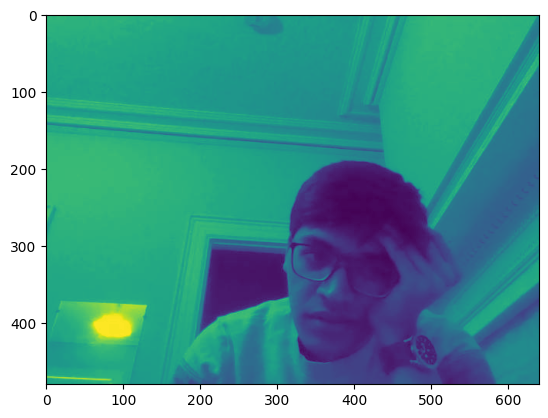

In [3]:
success, frame = webcam.read()
if success:
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    plt.imshow(frame)
    plt.plot()

In [4]:
def rescaleFrame(frame: Mat | ndarray[Any, dtype[generic]] | ndarray, scale) -> UMat:
    height = int(frame.shape[0] * scale)
    width = int(frame.shape[1] * scale)
    return cv.resize(frame, (width, height), interpolation=cv.INTER_AREA)

In [5]:
def setResLiveVideo(frame: VideoCapture, width: int):
    # given the width we automatically figure out the height
    scale = width / frame.get(3)
    height = int(frame.get(4) * scale)
    webcam.set(3, width)
    webcam.set(4, height)

In [6]:
# rescale frame for faster computation
#setResLiveVideo(webcam, 500)

In [7]:
while True:
    success, frame = webcam.read()
    if not success:
        print('Failed to capture frame')
        break

    # convert the video frame into a binary image
    # so that all pixels that look like skin color
    # are included in the binary object
    def is_skin_pixel(pixel):
        # Extract ARGB values
        A = (pixel >> 24) & 0xFF
        R = (pixel >> 16) & 0xFF
        G = (pixel >> 8) & 0xFF
        B = pixel & 0xFF

        # Convert to HSV
        hsv = cv.cvtColor(np.uint8([[pixel]]), cv.COLOR_BGR2HSV)[0][0]
        H = hsv[0]
        S = hsv[1]

        # Convert to YCrCb
        ycrcb = cv.cvtColor(np.uint8([[pixel]]), cv.COLOR_BGR2YCrCb)[0][0]
        Y = ycrcb[0]
        Cr = ycrcb[1]
        Cb = ycrcb[2]

        # Apply conditions
        skin_conditions = (
            (0.0 <= H <= 50.0) and (0.23 <= S <= 0.68) and
            (R > 95) and (G > 40) and (B > 20) and (R > G) and (R > B) and (abs(R - G) > 15) and (A > 15) and
            (Cr > 135) and (Cb > 85) and (Y > 80) and
            (Cr <= (1.5862*Cb)+20) and (Cr >= (0.3448*Cb)+76.2069) and
            (Cr >= (-4.5652*Cb)+234.5652) and (Cr <= (-1.15*Cb)+301.75) and (Cr <= (-2.2857*Cb)+432.85)
        )

        return skin_conditions

    height, width = frame.shape[:2]
    skin_mask = np.zeros((height, width), dtype=np.uint8)

    for y in range(height):
        for x in range(width):
            if is_skin_pixel(frame[y, x]):
                skin_mask[y, x] = 255


    # smooth out the image via median blur (take the median of surrounding pixels)
    # effective for removing the noise
    frame = cv.medianBlur(frame,13)

    cv.imshow('Video 1', frame)

    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    _, thres_output = cv.threshold(gray, 10, 255, cv.THRESH_BINARY)

    thres_output = cv.erode(thres_output, np.array([13, 13]), iterations=3)

    # find largest object in the binary image
    contours, _ = cv.findContours(thres_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv.contourArea(x), reverse=True)

    # draw the largest object
    if len(contours) > 0:
        x, y, w, h = cv.boundingRect(contours[0])
        thres_output = cv.rectangle(thres_output, (x, y), (x+w, y+h), (0, 255, 0), 4)

    # get rid of everything except the largest object
    mask = np.zeros(thres_output.shape, dtype=np.uint8)
    cv.drawContours(mask, contours, 0, (255, 255, 255), -1)
    thres_output = cv.bitwise_and(thres_output, mask)
    # fill holes in the contour
    cv.fillPoly(thres_output, pts =[contours[0]], color=(255,255,255))

    cv.imshow('Video 3', thres_output)

    if cv.waitKey(20) & 0xFF==ord('d'):
        break

KeyboardInterrupt: 